In [51]:
## imports for data preprocessing and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nilaymenon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nilaymenon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.
Plot your data. For tabular data, you will need to run scatters, for image data, you will need to plot your example classes.
How will you preprocess your data? You should explain this in your readme.md file and link your jupyter notebook to it. Your jupyter notebook should be uploaded to your repo.
Jupyter Notebook data download and environment setup requirements: 


In [104]:
df = pd.read_csv('Glassdoor_Job_Postings.csv')
df.head(5)

,company,job_title,company_rating,job_description,location,salary_avg_estimate,salary_estimate_payperiod,company_size,company_founded,employment_type,industry,sector,revenue,career_opportunities_rating,comp_and_benefits_rating,culture_and_values_rating,senior_management_rating,work_life_balance_rating
0,ABB,Junior Data Analyst,4.0,Junior Data Analyst\nTake your next career ste...,Bengaluru,"₹3,25,236",/yr (est.),10000+ Employees,1883,Company - Public,Electronics Manufacturing,Manufacturing,$10+ billion (USD),3.7,3.6,4.0,3.5,3.9
1,Philips,Data Scientist - AI/ML,4.0,Job Title\nData Scientist - AI/ML\nJob Descrip...,Bengaluru,NaN,NaN,10000+ Employees,1891,Company - Public,Healthcare Services & Hospitals,Healthcare,$10+ billion (USD),3.8,3.7,4.0,3.5,4.0
2,HSBC,Data Science GSC’s,3.9,Job description\nGraduate/ Post-graduate degre...,Bengaluru,NaN,NaN,10000+ Employees,1865,Company - Public,Banking & Lending,Finance,$10+ billion (USD),3.6,3.6,3.8,3.4,3.7
3,Facctum Solutions,Data Analyst,NaN,Job Description\nExperience: 0 - 2 years in da...,Karnataka,NaN,NaN,1 to 50 Employees,--,Company - Private,--,--,Unknown / Non-Applicable,NaN,NaN,NaN,NaN,NaN
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.0,JOB DESCRIPTION\n\nYou are a strategic thinker...,India,NaN,NaN,10000+ Employees,1799,Company - Public,Banking & Lending,Finance,$10+ billion (USD),4.0,3.9,3.9,3.6,3.7


## Data Preprocessing

In [105]:
# convert company_founded to int
df['company_founded'] = df['company_founded'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)

In [106]:
# convert salary_avg_estimate to float
df['salary_avg_estimate'] = df['salary_avg_estimate'].apply(lambda x: float(str(x).replace('₹', '').replace(',', '')) if pd.notna(x) else np.nan)

In [107]:
# convert job_description to list
df['job_description'] = df['job_description'].apply(lambda x: x.split('\n') if pd.notna(x) else x)

### Data Imputation


In [108]:
# imputing "unknown" if company is not known
df['company'] = df['company'].fillna('Unknown')

## imputing ratings for company related ratings
df['career_opportunities_rating'] = df['career_opportunities_rating'].fillna(df['career_opportunities_rating'].mean())
df['comp_and_benefits_rating'] = df['comp_and_benefits_rating'].fillna(df['comp_and_benefits_rating'].mean())
df['culture_and_values_rating'] = df['culture_and_values_rating'].fillna(df['culture_and_values_rating'].mean())
df['senior_management_rating'] = df['senior_management_rating'].fillna(df['senior_management_rating'].mean())
df['work_life_balance_rating'] = df['work_life_balance_rating'].fillna(df['work_life_balance_rating'].mean())


## company rating imputation, using the average of the company related ratings to impute missing data
## in company_rating
columns_to_average = ['career_opportunities_rating',
'comp_and_benefits_rating',       
'culture_and_values_rating',      
'senior_management_rating',       
'work_life_balance_rating']

average_values = df[columns_to_average].mean(axis = 1)


df['company_rating'] = df['company_rating'].fillna(average_values)

## Using KNNimputer to help us impute salary_avg_estimate using the correct columns
df.dropna(subset = ['job_description'],inplace = True)


columns_to_drop = ['company', 'job_title', 'job_description', 'location', 'salary_estimate_payperiod',
                   'company_size', 'company_founded', 'employment_type', 'industry', 'sector', 'revenue']

data_for_imputation = df.drop(columns = columns_to_drop)

data_for_imputation = pd.get_dummies(data_for_imputation)

imputer = KNNImputer()

imputed_data = imputer.fit_transform(data_for_imputation)

df['salary_avg_estimate'] = imputed_data[:, data_for_imputation.columns.get_loc('salary_avg_estimate')]


# imputing salary_estimate_payperiod with mode of column
df['salary_estimate_payperiod'] = df['salary_estimate_payperiod'].fillna(df['salary_estimate_payperiod'].mode()[0])


# imputing "unknown" for company size 
df['company_size'] = df['company_size'].fillna('Unknown')


# imputing the year 0000.0 for missing data in company_founded column
df['company_founded'] = df['company_founded'].fillna(0000.0)


# Imputing "unknown" for employment_type, industry, and sector and replacing ""--"" with "unknown"
df['employment_type'] = df['employment_type'].fillna('Unknown')
df['industry'] = df['industry'].fillna('Unknown')
df['industry'] = df['industry'].replace('--','Unknown')

df['revenue'] = df['revenue'].fillna('Unknown')

df['sector'] = df['sector'].fillna('Unknown')
df['sector'] = df['sector'].replace('--','Unknown')

In [109]:
# Converting our salary_estimate_payperiod and salary_avg_estimate into one feature given that 
# salary_estimate_payperiod gives us wheter or not the salary mentioned in 
# salary_avg_estimate is hourly, monthly, or yearly 
factors = {'/yr (est.)': 1,
          '/mo (est.)': 12,
          '/hr (est.)': 2123}

df['salary_estimate_payperiod'] = df['salary_estimate_payperiod'].apply(lambda x: factors[x] if (type(x) == str) else x)

df['salary_avg_estimate'] = df['salary_avg_estimate'] * df['salary_estimate_payperiod']

df = df.rename(columns={'salary_avg_estimate': 'salary_avg_estimate_per_year'})
df.drop(columns = 'salary_estimate_payperiod')

,company,job_title,company_rating,job_description,location,salary_avg_estimate_per_year,company_size,company_founded,employment_type,industry,sector,revenue,career_opportunities_rating,comp_and_benefits_rating,culture_and_values_rating,senior_management_rating,work_life_balance_rating
0,ABB,Junior Data Analyst,4.000000,"[Junior Data Analyst, Take your next career st...",Bengaluru,325236.0,10000+ Employees,1883.0,Company - Public,Electronics Manufacturing,Manufacturing,$10+ billion (USD),3.700000,3.600000,4.00000,3.500000,3.900000
1,Philips,Data Scientist - AI/ML,4.000000,"[Job Title, Data Scientist - AI/ML, Job Descri...",Bengaluru,657767.6,10000+ Employees,1891.0,Company - Public,Healthcare Services & Hospitals,Healthcare,$10+ billion (USD),3.800000,3.700000,4.00000,3.500000,4.000000
2,HSBC,Data Science GSC’s,3.900000,"[Job description, Graduate/ Post-graduate degr...",Bengaluru,615428.4,10000+ Employees,1865.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),3.600000,3.600000,3.80000,3.400000,3.700000
3,Facctum Solutions,Data Analyst,3.780438,"[Job Description, Experience: 0 - 2 years in d...",Karnataka,534300.0,1 to 50 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,3.838304,3.678796,3.90301,3.677702,3.804378
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.000000,"[JOB DESCRIPTION, , You are a strategic thinke...",India,574184.4,10000+ Employees,1799.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),4.000000,3.900000,3.90000,3.600000,3.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,Kpro Solutions,Analytics & Data Science,4.000000,"[Experience & Qualification:, , Minimum of 9 y...",Bengaluru,483915.0,1 to 50 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,4.000000,4.000000,4.00000,4.000000,4.000000
896,Athena Global Technologies,Data Engineer,3.900000,"[Immediate requirement for Data Engineer, Expe...",Hyderābād,678949.0,51 to 200 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,4.200000,3.500000,4.00000,3.900000,3.900000
897,Wesco,India-Bangalore: Data Engineer,3.700000,[This person will work independently or with a...,Bengaluru,651920.0,10000+ Employees,1922.0,Company - Public,Wholesale,Retail & Wholesale,$10+ billion (USD),3.500000,3.400000,3.60000,3.300000,3.800000
898,Course5,Data Scientist,4.200000,[If you meet our position requirements and can...,Bengaluru,424426.0,1001 to 5000 Employees,2000.0,Company - Private,Business Consulting,Management & Consulting,$100 to $500 million (USD),4.300000,4.100000,4.30000,4.100000,4.200000


In [110]:
# making bins to define a salary range for where each salary range would belong  
bins = np.arange(min(df['salary_avg_estimate_per_year']),max(df['salary_avg_estimate_per_year']), 500000)

labels = range(len(bins) - 1)


df['salary_range'] = pd.cut(df['salary_avg_estimate_per_year'], bins=bins, labels=labels, include_lowest=True)
df
df = df.dropna(subset='salary_range')


### TFIDF attempt

In [111]:
# # Convert lists to strings
# df['job_description'] = df['job_description'].apply(lambda x: ' '.join(x))

# tfidf_vectorizer = TfidfVectorizer()

# tfidf_vectorizer.fit(df['job_description'])

# tfidf_matrix = tfidf_vectorizer.transform(df['job_description'])


## Data Exploration

## Plots

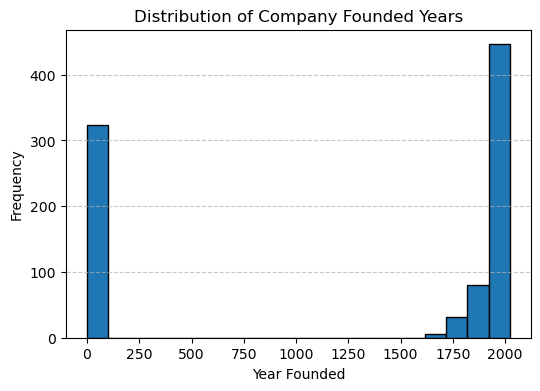

In [61]:
# plotting histogram of companies and the years they were founded
plt.figure(figsize=(6, 4))
plt.hist(df['company_founded'], bins=20, edgecolor='black')
plt.xlabel('Year Founded')
plt.ylabel('Frequency')
plt.title('Distribution of Company Founded Years')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [127]:
df['avg_rating'] = (df['career_opportunities_rating']+df['comp_and_benefits_rating']+ df['culture_and_values_rating']+df['senior_management_rating']+ df['work_life_balance_rating'])/5
df['avg_rating']

0      3.740000
1      3.800000
2      3.620000
3      3.780438
4      3.820000
         ...   
895    4.000000
896    3.900000
897    3.520000
898    4.200000
899    4.540000
Name: avg_rating, Length: 887, dtype: float64

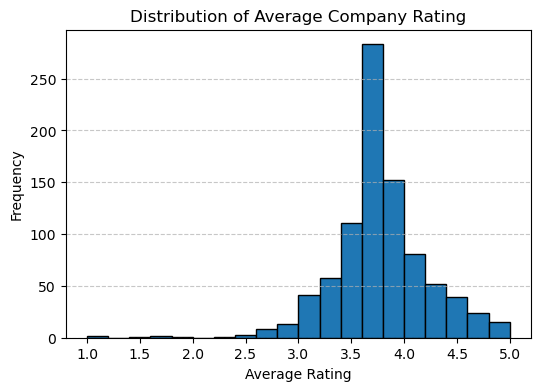

In [63]:
# histogram of average company ratings 
plt.figure(figsize=(6, 4))
plt.hist(df['avg_rating'], bins=20, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Company Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

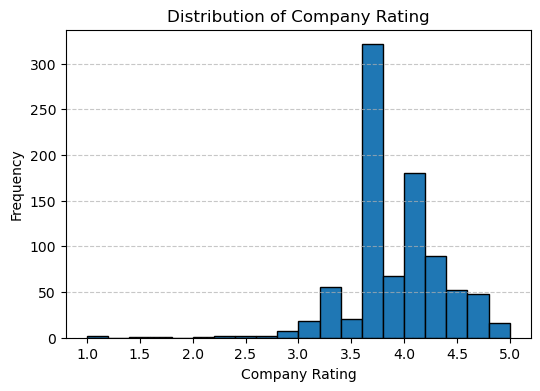

In [64]:
# histogram of company ratings 
plt.figure(figsize=(6, 4))
plt.hist(df['company_rating'], bins=20, edgecolor='black')
plt.xlabel('Company Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Company Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

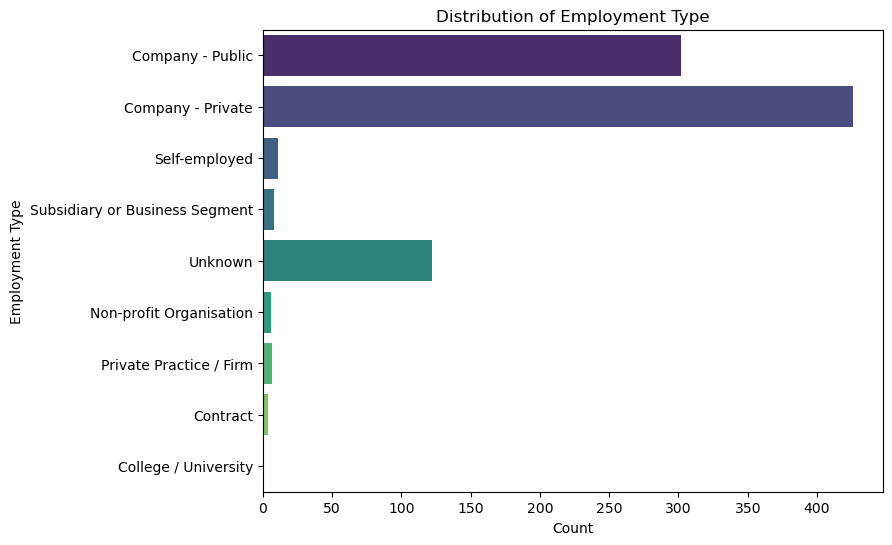

In [65]:
# countplot of number of companies in each employment type
plt.figure(figsize=(8, 6))
sns.countplot(y='employment_type', data=df, palette='viridis')
plt.title('Distribution of Employment Type')
plt.xlabel('Count')
plt.ylabel('Employment Type')
plt.show()

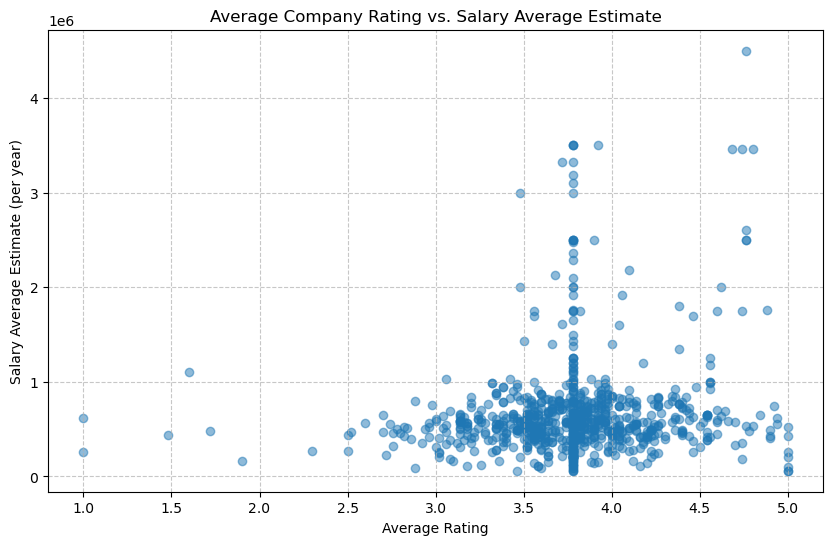

In [128]:
# scatter plot of average company rating vs salary_avg_estimate_per_year
plt.figure(figsize=(10, 6))
plt.scatter(df['avg_rating'], df['salary_avg_estimate_per_year'], alpha=0.5)
plt.xlabel('Average Rating')
plt.ylabel('Salary Average Estimate (per year)')
plt.title('Average Company Rating vs. Salary Average Estimate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Confusion matrix for correlation

/var/folders/n7/2mt83wy124sgy8t09zyv84sm0000gn/T/ipykernel_77999/3531766010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['salary_range'] = pd.to_numeric(selected_data['salary_range'], errors='coerce')


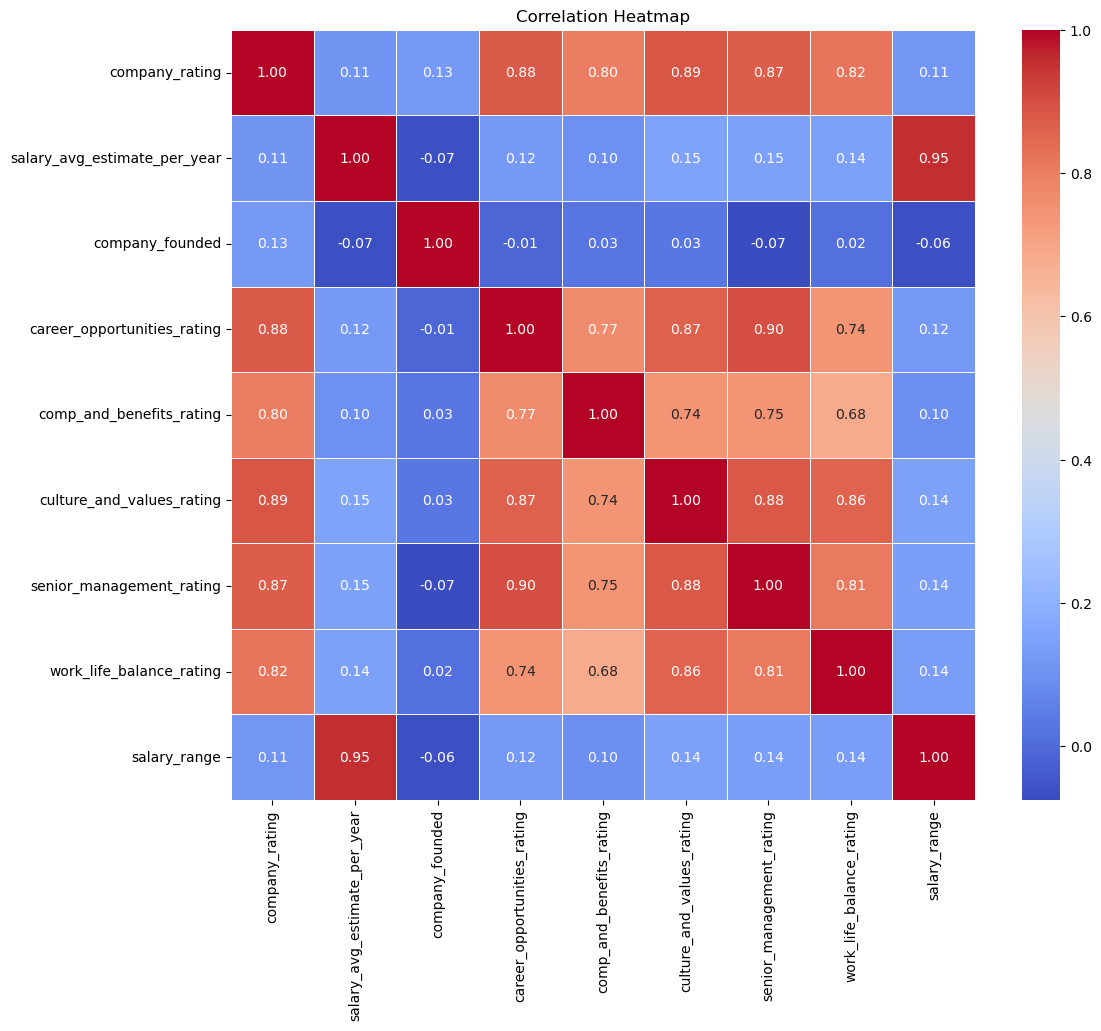

In [68]:
selected_columns = ['company_rating','salary_avg_estimate_per_year',
                    'company_size', 'company_founded','career_opportunities_rating',
'comp_and_benefits_rating',       
'culture_and_values_rating',      
'senior_management_rating',       
'work_life_balance_rating', 'salary_range']

selected_data = df[selected_columns]


# converting salary_range to numeric values if not already numeric to use in correlation matrix 
selected_data['salary_range'] = pd.to_numeric(selected_data['salary_range'], errors='coerce')

# dropping missing values if there are any in salary_range 
selected_data = selected_data.dropna(subset=['salary_range'])

# correlation matrix
correlation_matrix = selected_data.corr()

# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


### Model 1: Random Forest Classifier

In [69]:
# imports for Random Forest Classifier and other data preprocessing 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


# features to use
X = df[['company_rating', 'company_founded','career_opportunities_rating',
'comp_and_benefits_rating',       
'culture_and_values_rating',      
'senior_management_rating',       
'work_life_balance_rating']]

# target 
y = df['salary_range']

# splitting into train val test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
# MinMaxScaler on x train 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
# Making RFC model using n_estimators = 100
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

predictions = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:}")

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)



Accuracy: 0.68
Mean Squared Error: 1.1123595505617978


### Confusion matrix 

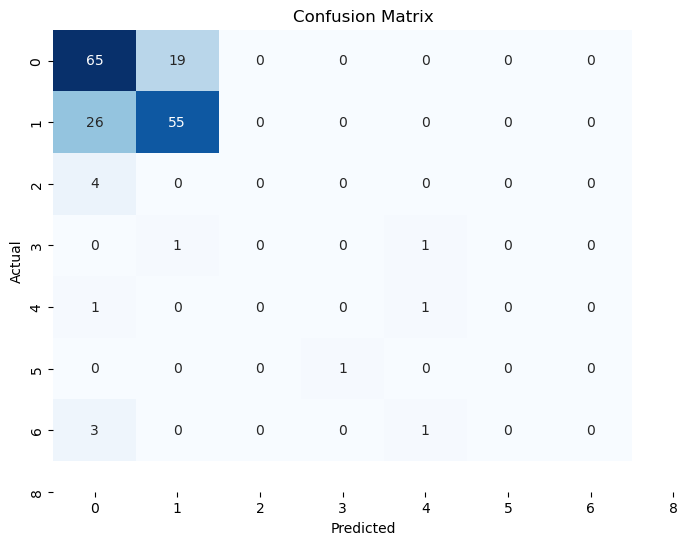

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Fitting plot 

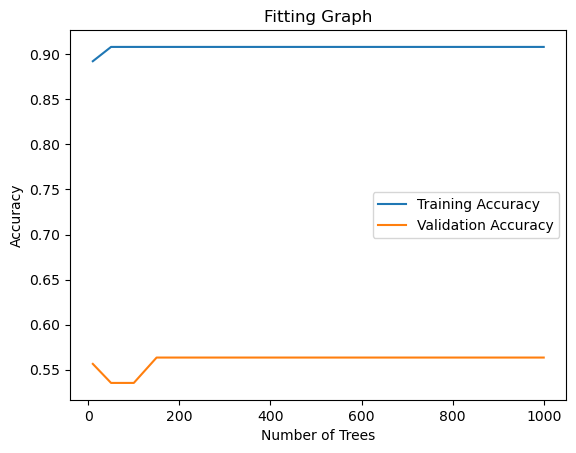

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# making fitting graph for n_estimators parameter and plotting train and val accuracy 
# given each parameter input 
param_values = [10, 50, 100, 150, 200, 500, 1000]

train_scores = []
val_scores = []

for param in param_values:
    clf = RandomForestClassifier(n_estimators=param, random_state=42)
    clf.fit(X_train_scaled, y_train)

    train_predictions = clf.predict(X_train_scaled)
    val_predictions = clf.predict(X_val_scaled)

    train_accuracy = accuracy_score(y_train, train_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)

    train_scores.append(train_accuracy)
    val_scores.append(val_accuracy)

plt.plot(param_values, train_scores, label = 'Training Accuracy')
plt.plot(param_values, val_scores, label = 'Validation Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Fitting Graph')
plt.legend()
plt.show()


### MSE for train,val,and test

In [72]:
from sklearn.metrics import mean_squared_error, accuracy_score

# finding out the train, validation, and testing accuracy and MSE for n_estimators of 100
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)


train_predictions = clf.predict(X_train_scaled)


train_accuracy = accuracy_score(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)
print("Training Mean Squared Error:", train_mse)

val_predictions = clf.predict(X_val_scaled)


val_accuracy = accuracy_score(y_val, val_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
print("\nValidation Accuracy:", val_accuracy)
print("Validation Mean Squared Error:", val_mse)


test_predictions = clf.predict(X_test_scaled)


test_accuracy = accuracy_score(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
print("\nTesting Accuracy:", test_accuracy)
print("Testing Mean Squared Error:", test_mse)

Training Accuracy: 0.908289241622575
Training Mean Squared Error: 0.4497354497354497

Validation Accuracy: 0.5352112676056338
Validation Mean Squared Error: 1.9507042253521127

Testing Accuracy: 0.6797752808988764
Testing Mean Squared Error: 1.1123595505617978


### Model 2: Decision Tree Classifier

In [114]:
# features to use
X = df[['company_rating', 'company_founded', 'career_opportunities_rating',
        'comp_and_benefits_rating', 'culture_and_values_rating',
        'senior_management_rating', 'work_life_balance_rating']]
# target
y = df['salary_range']

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# grid search for decision tree classifier parameters
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2]
}

# decision tree classifier
tree_model = DecisionTreeClassifier(random_state=1)

# grid search with cross-validation
grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# using best parameters found by our grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_tree_model = grid_search.best_estimator_
y_pred = best_tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

/Users/nilaymenon/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'splitter': 'best'}
Test Accuracy: 0.702247191011236


### Fitting Graph for Decision Tree

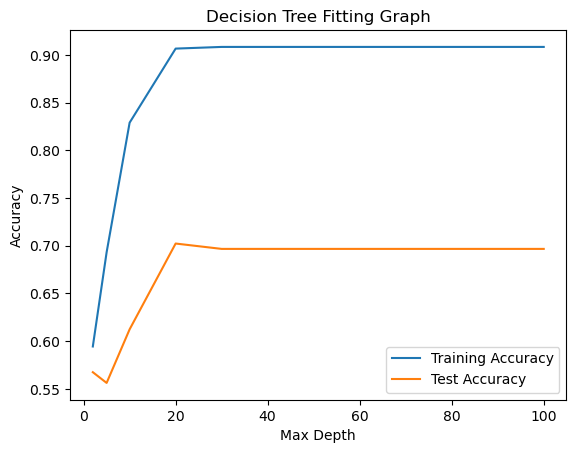

In [75]:
# max_depth values to test our fitting graph on train and test accuracy  
max_depth_values = [2, 5, 10, 20, 30, 50, 100]

train_scores = []
val_scores = []

for max_depth in max_depth_values:
    # decision tree model with current max_depth
    tree_model = DecisionTreeClassifier(max_depth=max_depth, random_state=1)
    tree_model.fit(X_train, y_train)

    train_predictions = tree_model.predict(X_train)
    val_predictions = tree_model.predict(X_test)

    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, val_predictions)

    train_scores.append(train_accuracy)
    val_scores.append(test_accuracy)

plt.plot(max_depth_values, train_scores, label = 'Training Accuracy')
plt.plot(max_depth_values, val_scores, label = 'Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Fitting Graph')
plt.legend()
plt.savefig('decision_tree.jpg')
plt.show()
plt.show()

In [76]:
# predictions on training set using best decision tree model 
# and calculating accuracy and mse
train_predictions = best_tree_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)

print("Training Accuracy:", train_accuracy)
print("Training Mean Squared Error:", train_mse)

# predictions on val set using best decision tree model 
# and calculating accuracy and mse
val_predictions = best_tree_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_mse = mean_squared_error(y_val, val_predictions)

print("\nValidation Accuracy:", val_accuracy)
print("Validation Mean Squared Error:", val_mse)

# predictions on test set using best decision tree model 
# and calculating accuracy and mse
test_predictions = best_tree_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("\nTesting Accuracy:", test_accuracy)
print("Testing Mean Squared Error:", test_mse)


Training Accuracy: 0.9065255731922398
Training Mean Squared Error: 0.4514991181657848

Validation Accuracy: 0.5774647887323944
Validation Mean Squared Error: 1.8943661971830985

Testing Accuracy: 0.702247191011236
Testing Mean Squared Error: 1.0337078651685394


### Model 3: XGBoost Model

In [82]:
!pip install xgboost

python(43028) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.0 MB/s eta 0:00:0000:0100:01


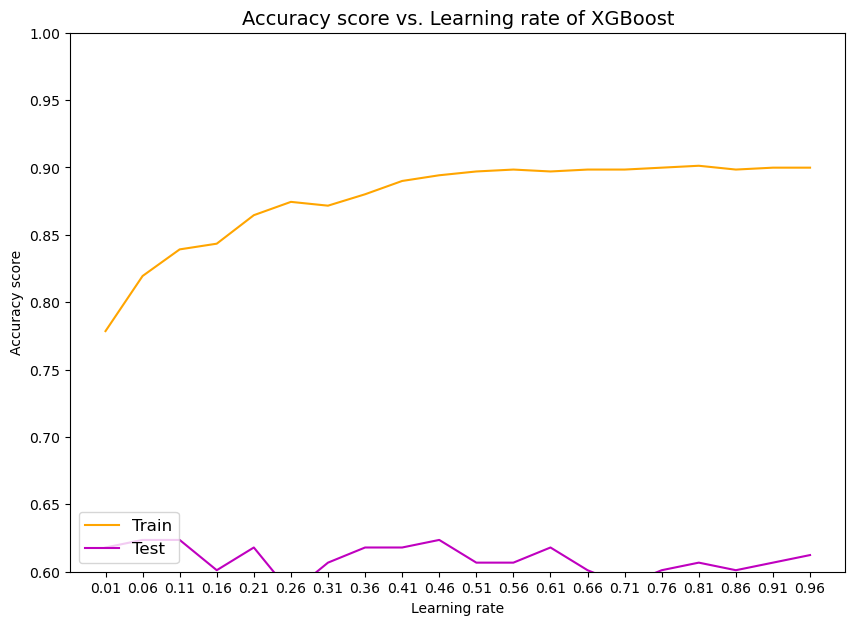

Accuracy: 0.398876404494382


/Users/nilaymenon/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/nilaymenon/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
243 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
243 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nilaymenon/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nilaymenon/opt/anaconda3/lib/python3.9/site-pa

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: nan


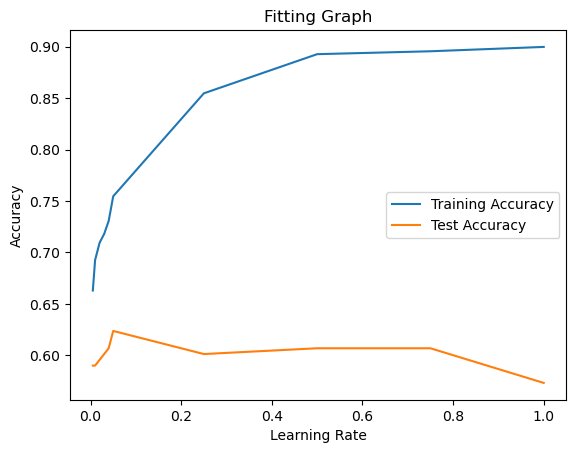

In [121]:
 #
import xgboost as xgb
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.where(y_train == 8, 7, y_train)

# XGBoost model initialization with different learning rates 
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = [] 
train_XG = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(learning_rate=lr, max_depth=10, n_estimators=10, subsample=1, colsample_bytree=.8)
    xgb_classifier.fit(x_train, y_train)
    train_XG.append(xgb_classifier.score(x_train, y_train))
    test_XG.append(xgb_classifier.score(x_test, y_test))
# plotting learning rate vs the accuracy score for both test and train sets
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# hyperparameters for tuning using gridsearch
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# getting best hyperparameters and score and using that model 
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

xgb_classifier = xgb.XGBClassifier(learning_rate=.05, max_depth=3, n_estimators=100, subsample=.8, colsample_bytree=.8)
xgb_classifier.fit(x_train, y_train)
xgb_classifier.score(x_test, y_test), xgb_classifier.score(x_train, y_train)

import matplotlib.pyplot as plt
import numpy as np
# plotting fitting graph for both the test and train accuracy given the learning rate is variable
param_values = [.005,.01,.02,.03,.04,.05,.25,.5,.75,1.0]
train_scores = []
test_scores = []

for param in param_values:
    xgb_classifier = xgb.XGBClassifier(learning_rate=param, max_depth=3, n_estimators=100, subsample=.8, colsample_bytree=.8)
    xgb_classifier.fit(x_train, y_train)


    train_accuracy = xgb_classifier.score(x_train, y_train)
    test_accuracy = xgb_classifier.score(x_test, y_test)

    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

plt.plot(param_values, train_scores, label='Training Accuracy')
plt.plot(param_values, test_scores, label='Test Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('XGBoost Fitting Graph')
plt.legend()
plt.show()